# Perform linear model per CellProfiler feature


## Import libraries


In [1]:
import pathlib

import pandas as pd
from pycytominer import feature_select
from pycytominer.cyto_utils import infer_cp_features
from sklearn.linear_model import LinearRegression

## Set up paths and variables


In [2]:
# Define inputs and outputs
data_dir = pathlib.Path("../../../3.processing_features/data/single_cell_profiles/")
cp_file = pathlib.Path(data_dir, "Plate_5_sc_normalized.parquet")

output_dir = pathlib.Path("./results")
output_dir.mkdir(exist_ok=True)
output_cp_file = pathlib.Path(output_dir, "linear_model_cp_features_plate5_WT_HET.tsv")


## Read in normalized data


In [3]:
# Load data
cp_df = pd.read_parquet(cp_file)

# Remove rows where Metadata_genotype is a certain genotype to avoid using in the LM
cp_df = cp_df[cp_df["Metadata_genotype"] != "Null"]

# Make sure there are no NaNs
cp_df = feature_select(
        cp_df,
        operation="drop_na_columns",
        na_cutoff=0
    )
    

# Define CellProfiler features
cp_features = infer_cp_features(cp_df)

print(f"We are testing {len(cp_features)} CellProfiler features")
print(cp_df.shape)
cp_df.head()


We are testing 2287 CellProfiler features
(4369, 2304)


,Metadata_WellRow,Metadata_WellCol,Metadata_Well,Metadata_Site,Metadata_number_of_singlecells,Metadata_gene_name,Metadata_genotype,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,...,Nuclei_Texture_Variance_DAPI_3_02_256,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256
0,B,1,B1,10,79,NF1,WT,870.435339,133.774194,863.193505,...,-0.589702,-0.585393,-0.523726,-0.514327,-0.526490,-0.522161,0.214989,0.273449,0.214783,0.183755
1,B,1,B1,11,79,NF1,WT,827.549320,342.283025,810.793536,...,-0.748197,-0.748387,-0.465471,-0.445058,-0.464277,-0.450122,-0.258725,-0.260480,-0.263612,-0.256463
2,B,1,B1,11,79,NF1,WT,427.937346,356.977306,406.334199,...,0.231161,0.221558,0.444134,0.547131,0.644409,0.433607,-0.385501,-0.384362,-0.374862,-0.380044
3,B,1,B1,11,79,NF1,WT,272.036245,389.802436,282.897144,...,-0.219816,-0.219022,-0.230114,-0.254531,-0.234149,-0.138286,-0.328111,-0.317422,-0.331309,-0.330312
4,B,1,B1,11,79,NF1,WT,944.416824,736.917498,963.654663,...,-0.230233,-0.217203,0.208971,0.193882,0.140452,0.136724,-0.498345,-0.493748,-0.496570,-0.494255


## Set up the dummy matrix between Null and WT cell types


In [4]:
# Setup linear modeling framework
variables = ["Metadata_number_of_singlecells"]
X = cp_df.loc[:, variables]

# Add dummy matrix of categorical genotypes
genotype_x = pd.get_dummies(data=cp_df.Metadata_genotype)

X = pd.concat([X, genotype_x], axis=1)

print(X.shape)
X.head()

(4369, 3)


,Metadata_number_of_singlecells,HET,WT
0,79,0,1
1,79,0,1
2,79,0,1
3,79,0,1
4,79,0,1


## Perform linear modeling per feature


In [5]:
# Fit linear model for each feature
lm_results = []
for cp_feature in cp_features:
    # Subset CP data to each individual feature (univariate test)
    cp_subset_df = cp_df.loc[:, cp_feature]

    # Fit linear model
    lm = LinearRegression(fit_intercept=True)
    lm_result = lm.fit(X=X, y=cp_subset_df)

    # Extract Beta coefficients
    # (contribution of feature to X covariates)
    coef = lm_result.coef_

    # Estimate fit (R^2)
    r2_score = lm.score(X=X, y=cp_subset_df)

    # Add results to a growing list
    lm_results.append([cp_feature, r2_score] + list(coef))

# Convert results to a pandas DataFrame
lm_results = pd.DataFrame(
    lm_results,
    columns=["feature", "r2_score", "cell_count_coef", "HET_coef", "WT_coef"],
)

# Output file
lm_results.to_csv(output_cp_file, sep="\t", index=False)

print(lm_results.shape)
lm_results.head()


(2287, 5)


,feature,r2_score,cell_count_coef,HET_coef,WT_coef
0,Cytoplasm_AreaShape_Area,0.009853,-0.003549,0.052613,-0.052613
1,Cytoplasm_AreaShape_BoundingBoxArea,0.014113,-0.001710,0.110601,-0.110601
2,Cytoplasm_AreaShape_BoundingBoxMaximum_X,0.000390,0.000837,0.022414,-0.022414
3,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,0.004862,-0.001923,0.043768,-0.043768
4,Cytoplasm_AreaShape_BoundingBoxMinimum_X,0.000696,0.001069,-0.009882,0.009882


## Check to make sure the processing worked


/home/jenna/mambaforge/envs/python_analysis_nf1/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='cell_count_coef', ylabel='HET_coef'>

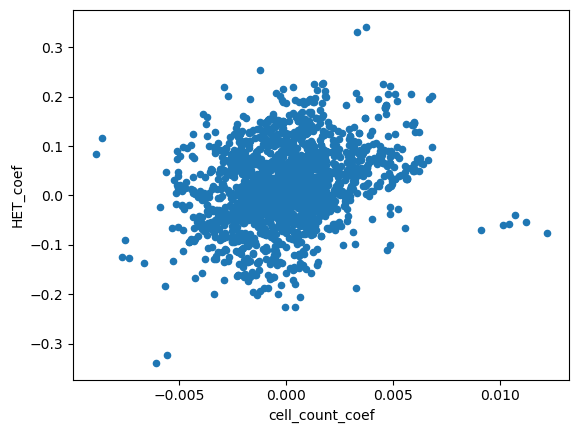

In [6]:
# Small exploration visualization
lm_results.plot(x="cell_count_coef", y="HET_coef", kind="scatter")
